# Descrete Anomaly Detection Exercise

Use basic probability to identify anomalous requests. 

Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

pd.options.display.max_rows = None

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [3]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
#df.head()

In [4]:
df = df.entry.apply(parse_log_entry)
#df.head()

In [5]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)
#df.head()

In [6]:
df['size_mb'] = df['size'] / 1024 / 1024

In [7]:
df.timestamp = pd.to_datetime(df.timestamp)

In [8]:
df = df.set_index('timestamp')
#df.head()

## IP (Lesson)

In [9]:
df.ip.value_counts(),\
df.ip.value_counts(normalize=True)

(97.105.19.58      11999
 173.173.113.51     1059
 72.181.113.170      613
 72.181.105.81       246
 68.201.219.223       21
 24.26.242.9          21
 35.175.171.137        2
 52.87.230.102         2
 70.121.214.34         2
 52.90.165.200         1
 95.31.16.121          1
 95.31.18.119          1
 45.23.250.16          1
 52.91.30.150          1
 34.207.64.242         1
 3.88.129.158          1
 54.172.14.223         1
 3.92.201.136          1
 35.174.209.2          1
 54.145.52.184         1
 34.229.70.250         1
 97.105.15.120         1
 Name: ip, dtype: int64,
 97.105.19.58      0.858420
 173.173.113.51    0.075762
 72.181.113.170    0.043855
 72.181.105.81     0.017599
 68.201.219.223    0.001502
 24.26.242.9       0.001502
 35.175.171.137    0.000143
 52.87.230.102     0.000143
 70.121.214.34     0.000143
 52.90.165.200     0.000072
 95.31.16.121      0.000072
 95.31.18.119      0.000072
 45.23.250.16      0.000072
 52.91.30.150      0.000072
 34.207.64.242     0.000072
 3.88

In [10]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<AxesSubplot:>

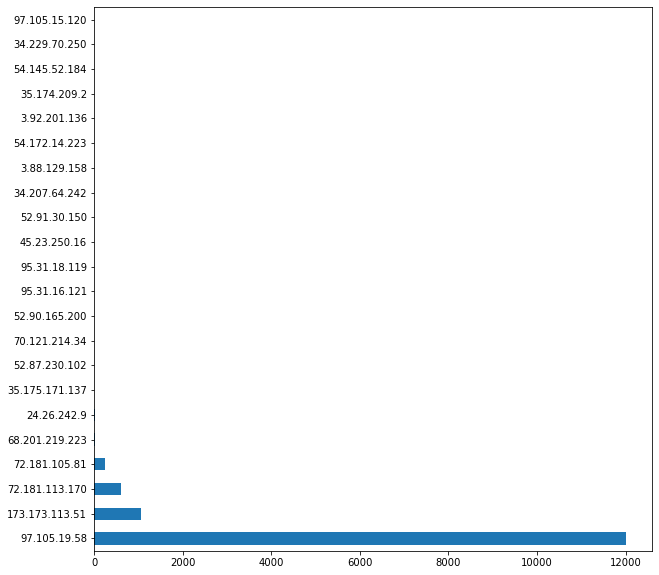

In [11]:
ip_df['count'].plot.barh(figsize=(10,10))

<AxesSubplot:>

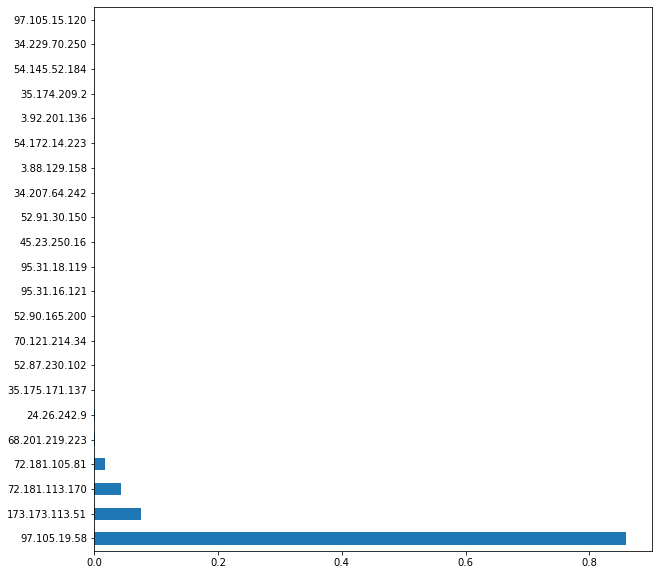

In [12]:
ip_df['proba'].plot.barh(figsize=(10,10))

## IP vs Status (Lesson)

In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [14]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [15]:
df[df.ip == '97.105.15.120']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [16]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


## Explore Others

In [17]:
for col in df.columns:
    print(f'\n{col}')
    print('-----------------')
    print(df[col].value_counts())
    print('-----------------\n')


ip
-----------------
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64
-----------------


request_method
-----------------
GET    13978
Name: request_method, dtype: int64
-----------------


request_path
-----------------
/api/v1/sales?page=2                       709
/api/v1/items                              464
/api/v1/items?page=2                       291
/api/v1/items?page=3                       219
/api/v1/stores                             162
/api/v1/sales                           

- user_agent
- size
- request path

## ip vs user_agent

In [18]:
user_agent_ip = (
    df.groupby('ip')
    .user_agent.value_counts(normalize=True)
    .rename('proba_user_agent_ip')
    .reset_index()
)
user_agent_ip

,ip,user_agent,proba_user_agent_ip
0,173.173.113.51,python-requests/2.21.0,1.000000
1,24.26.242.9,python-requests/2.21.0,1.000000
2,3.88.129.158,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.000000
3,3.92.201.136,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.000000
4,34.207.64.242,Slackbot 1.0 (+https://api.slack.com/robots),1.000000
5,34.229.70.250,Slackbot 1.0 (+https://api.slack.com/robots),1.000000
6,35.174.209.2,Slackbot 1.0 (+https://api.slack.com/robots),1.000000
7,35.175.171.137,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.000000
8,45.23.250.16,python-requests/2.21.0,1.000000
9,52.87.230.102,Slackbot 1.0 (+https://api.slack.com/robots),0.500000


In [19]:
user_agent_ip[['ip']].value_counts()

ip            
97.105.19.58      5
72.181.105.81     3
72.181.113.170    2
52.87.230.102     2
54.145.52.184     1
97.105.15.120     1
95.31.18.119      1
95.31.16.121      1
70.121.214.34     1
68.201.219.223    1
54.172.14.223     1
173.173.113.51    1
24.26.242.9       1
52.90.165.200     1
45.23.250.16      1
35.175.171.137    1
35.174.209.2      1
34.229.70.250     1
34.207.64.242     1
3.92.201.136      1
3.88.129.158      1
52.91.30.150      1
dtype: int64

In [20]:
user_agent_ip[user_agent_ip.ip == '97.105.19.58']

,ip,user_agent,proba_user_agent_ip
25,97.105.19.58,python-requests/2.21.0,0.838320
26,97.105.19.58,python-requests/2.20.1,0.159263
27,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002167
28,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000167
29,97.105.19.58,Python-urllib/3.7,0.000083


In [21]:
user_agent_ip[user_agent_ip['proba_user_agent_ip'] < 1].sort_values(by='proba_user_agent_ip')

,ip,user_agent,proba_user_agent_ip
29,97.105.19.58,Python-urllib/3.7,0.000083
28,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000167
27,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002167
21,72.181.113.170,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.003263
18,72.181.105.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.032520
19,72.181.105.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.032520
26,97.105.19.58,python-requests/2.20.1,0.159263
9,52.87.230.102,Slackbot 1.0 (+https://api.slack.com/robots),0.500000
10,52.87.230.102,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.500000
25,97.105.19.58,python-requests/2.21.0,0.838320


## ip vs size

In [22]:
size_ip = (
    df.groupby('ip')
    ['size'].value_counts(normalize=True)
    .rename('proba_size_ip')
    .reset_index()
)
size_ip.head()

,ip,size,proba_size_ip
0,173.173.113.51,3561,0.060434
1,173.173.113.51,1787,0.058546
2,173.173.113.51,3659,0.058546
3,173.173.113.51,1328,0.050992
4,173.173.113.51,510134,0.013220


In [23]:
size_ip[['ip','size']].value_counts().unstack(0).sum()

ip
173.173.113.51    178.0
24.26.242.9         3.0
3.88.129.158        1.0
3.92.201.136        1.0
34.207.64.242       1.0
34.229.70.250       1.0
35.174.209.2        1.0
35.175.171.137      2.0
45.23.250.16        1.0
52.87.230.102       2.0
52.90.165.200       1.0
52.91.30.150        1.0
54.145.52.184       1.0
54.172.14.223       1.0
68.201.219.223      5.0
70.121.214.34       2.0
72.181.105.81     179.0
72.181.113.170    178.0
95.31.16.121        1.0
95.31.18.119        1.0
97.105.15.120       1.0
97.105.19.58      187.0
dtype: float64

In [24]:
size_ip[size_ip['ip'] == '97.105.19.58']

,ip,size,proba_size_ip
562,97.105.19.58,494819,0.057838
563,97.105.19.58,3561,0.034003
564,97.105.19.58,493905,0.015335
565,97.105.19.58,3659,0.014918
566,97.105.19.58,1328,0.013251
567,97.105.19.58,510134,0.013168
568,97.105.19.58,510142,0.013084
569,97.105.19.58,1787,0.010084
570,97.105.19.58,510139,0.009251
571,97.105.19.58,510144,0.009167


In [25]:
size_ip.groupby('ip')['size'].sum().sort_values(ascending=False)

ip
97.105.19.58      90410063
173.173.113.51    87321812
72.181.105.81     86912573
72.181.113.170    86912177
95.31.18.119       1153005
24.26.242.9         498794
52.87.230.102       494067
68.201.219.223        7772
35.175.171.137        3603
3.88.129.158          3561
97.105.15.120         2560
45.23.250.16          1328
95.31.16.121          1005
70.121.214.34          204
54.145.52.184          162
54.172.14.223          162
52.90.165.200          162
35.174.209.2           162
34.229.70.250          162
34.207.64.242          162
3.92.201.136            42
52.91.30.150            42
Name: size, dtype: int64

## ip vs request path`

In [26]:
request_path_ip = (
    df.groupby('ip')
    .request_path.value_counts(normalize=True)
    .rename('proba_request_path_ip')
    .reset_index()
)
request_path_ip.head()

,ip,request_path,proba_request_path_ip
0,173.173.113.51,/api/v1/items,0.060434
1,173.173.113.51,/api/v1/items?page=2,0.058546
2,173.173.113.51,/api/v1/items?page=3,0.058546
3,173.173.113.51,/api/v1/stores,0.050992
4,173.173.113.51,/api/v1/sales,0.007554


In [27]:
request_path_ip[['ip']].value_counts()

ip            
97.105.19.58      217
72.181.105.81     196
72.181.113.170    189
173.173.113.51    189
68.201.219.223      7
24.26.242.9         3
70.121.214.34       2
35.175.171.137      2
52.87.230.102       2
34.207.64.242       1
97.105.15.120       1
95.31.18.119        1
95.31.16.121        1
3.88.129.158        1
3.92.201.136        1
54.172.14.223       1
34.229.70.250       1
54.145.52.184       1
52.90.165.200       1
45.23.250.16        1
35.174.209.2        1
52.91.30.150        1
dtype: int64

## All together now

In [28]:
everything = status_given_ip.merge(user_agent_ip,on='ip').merge(size_ip,on='ip').merge(request_path_ip,on='ip')
everything.head()

,ip,status_code,proba_status_given_ip,user_agent,proba_user_agent_ip,size,proba_size_ip,request_path,proba_request_path_ip
0,173.173.113.51,200,1.0,python-requests/2.21.0,1.0,3561,0.060434,/api/v1/items,0.060434
1,173.173.113.51,200,1.0,python-requests/2.21.0,1.0,3561,0.060434,/api/v1/items?page=2,0.058546
2,173.173.113.51,200,1.0,python-requests/2.21.0,1.0,3561,0.060434,/api/v1/items?page=3,0.058546
3,173.173.113.51,200,1.0,python-requests/2.21.0,1.0,3561,0.060434,/api/v1/stores,0.050992
4,173.173.113.51,200,1.0,python-requests/2.21.0,1.0,3561,0.060434,/api/v1/sales,0.007554


In [29]:
everything.groupby('ip')['size'].sum().sort_values(ascending=False)

ip
97.105.19.58      196189836710
72.181.113.170     65705605812
72.181.105.81      51104592924
173.173.113.51     16503822468
52.87.230.102          1976268
24.26.242.9            1496382
95.31.18.119           1153005
68.201.219.223           54404
35.175.171.137            7206
3.88.129.158              3561
97.105.15.120             2560
45.23.250.16              1328
95.31.16.121              1005
70.121.214.34              408
34.207.64.242              162
54.172.14.223              162
34.229.70.250              162
54.145.52.184              162
52.90.165.200              162
35.174.209.2               162
3.92.201.136                42
52.91.30.150                42
Name: size, dtype: int64

### Top IP - user_agent by size

In [30]:
everything[everything.ip == '97.105.19.58'].user_agent.value_counts()

python-requests/2.21.0                                                                                                       81158
python-requests/2.20.1                                                                                                       81158
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    81158
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    81158
Python-urllib/3.7                                                                                                            81158
Name: user_agent, dtype: int64

In [31]:
everything[everything.ip == '72.181.113.170'].user_agent.value_counts()

python-requests/2.21.0                                                                                                       67284
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    67284
Name: user_agent, dtype: int64

In [32]:
everything[everything.ip == '72.181.105.81'].user_agent.value_counts()

python-requests/2.21.0                                                                                                       35084
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           35084
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    35084
Name: user_agent, dtype: int64

In [33]:
everything[everything.ip == '173.173.113.51'].user_agent.value_counts()

python-requests/2.21.0    33642
Name: user_agent, dtype: int64

In [34]:
everything[everything.ip == '52.87.230.102'].user_agent.value_counts()

Slackbot 1.0 (+https://api.slack.com/robots)                  4
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)    4
Name: user_agent, dtype: int64

In [35]:
everything[everything.ip == '24.26.242.9'].user_agent.value_counts()

python-requests/2.21.0    9
Name: user_agent, dtype: int64

In [36]:
everything[everything.ip == '95.31.18.119'].user_agent.value_counts()

python-requests/2.21.0    1
Name: user_agent, dtype: int64

### Top IP - Request path by size

In [37]:
everything[everything.ip == '97.105.19.58'].request_path.value_counts(normalize=True)

/api/v1/sales?page=2                       0.004608
/api/v1/sales?page=142                     0.004608
/api/v1/sales?page=131                     0.004608
/api/v1/sales?page=132                     0.004608
/api/v1/sales?page=133                     0.004608
/api/v1/sales?page=134                     0.004608
/api/v1/sales?page=135                     0.004608
/api/v1/sales?page=136                     0.004608
/api/v1/sales?page=137                     0.004608
/api/v1/sales?page=138                     0.004608
/api/v1/sales?page=139                     0.004608
/api/v1/sales?page=140                     0.004608
/api/v1/sales?page=141                     0.004608
/api/v1/sales?page=143                     0.004608
/api/v1/sales?page=86                      0.004608
/api/v1/sales?page=144                     0.004608
/api/v1/sales?page=145                     0.004608
/api/v1/sales?page=146                     0.004608
/api/v1/sales?page=147                     0.004608
/api/v1/sale

In [38]:
everything[everything.ip == '72.181.113.170'].request_path.value_counts()

/api/v1/items             712
/api/v1/sales?page=94     712
/api/v1/sales?page=86     712
/api/v1/sales?page=87     712
/api/v1/sales?page=88     712
/api/v1/sales?page=89     712
/api/v1/sales?page=9      712
/api/v1/sales?page=90     712
/api/v1/sales?page=91     712
/api/v1/sales?page=92     712
/api/v1/sales?page=93     712
/api/v1/sales?page=95     712
/api/v1/sales?page=84     712
/api/v1/sales?page=96     712
/api/v1/sales?page=97     712
/api/v1/sales?page=98     712
/api/v1/sales?page=99     712
/api/v1/stores            712
/api/v1/sales?page=134    712
/api/v1/sales?page=135    712
/api/v1/sales?page=136    712
/api/v1/sales?page=137    712
/api/v1/sales?page=85     712
/api/v1/sales?page=83     712
/api/v1/sales?page=60     712
/api/v1/sales?page=71     712
/api/v1/sales?page=62     712
/api/v1/sales?page=63     712
/api/v1/sales?page=64     712
/api/v1/sales?page=65     712
/api/v1/sales?page=66     712
/api/v1/sales?page=67     712
/api/v1/sales?page=68     712
/api/v1/sa

In [39]:
everything[everything.ip == '72.181.105.81'].request_path.value_counts()

/api/v1/items             537
/api/v1/sales?page=35     537
/api/v1/sales?page=37     537
/api/v1/sales?page=38     537
/api/v1/sales?page=39     537
/api/v1/sales?page=4      537
/api/v1/sales?page=40     537
/api/v1/sales?page=41     537
/api/v1/sales?page=42     537
/api/v1/sales?page=43     537
/api/v1/sales?page=44     537
/api/v1/sales?page=45     537
/api/v1/sales?page=46     537
/api/v1/sales?page=47     537
/api/v1/sales?page=48     537
/api/v1/sales?page=49     537
/api/v1/sales?page=5      537
/api/v1/sales?page=50     537
/api/v1/sales?page=51     537
/api/v1/sales?page=52     537
/api/v1/sales?page=53     537
/api/v1/sales?page=54     537
/api/v1/sales?page=55     537
/api/v1/sales?page=36     537
/api/v1/sales?page=34     537
/api/v1/items?page=2      537
/api/v1/sales?page=33     537
/api/v1/sales?page=18     537
/api/v1/sales?page=180    537
/api/v1/sales?page=181    537
/api/v1/sales?page=182    537
/api/v1/sales?page=183    537
/api/v1/sales?page=19     537
/api/v1/sa

In [40]:
everything[everything.ip == '173.173.113.51'].request_path.value_counts()

/api/v1/items             178
/api/v1/sales?page=146    178
/api/v1/sales?page=137    178
/api/v1/sales?page=138    178
/api/v1/sales?page=139    178
/api/v1/sales?page=140    178
/api/v1/sales?page=141    178
/api/v1/sales?page=142    178
/api/v1/sales?page=143    178
/api/v1/sales?page=144    178
/api/v1/sales?page=145    178
/api/v1/sales?page=147    178
/api/v1/sales?page=135    178
/api/v1/sales?page=148    178
/api/v1/sales?page=149    178
/api/v1/sales?page=150    178
/api/v1/sales?page=151    178
/api/v1/sales?page=152    178
/api/v1/sales?page=153    178
/api/v1/sales?page=154    178
/api/v1/sales?page=155    178
/api/v1/sales?page=156    178
/api/v1/sales?page=136    178
/api/v1/sales?page=134    178
/api/v1/sales?page=111    178
/api/v1/sales?page=122    178
/api/v1/sales?page=113    178
/api/v1/sales?page=114    178
/api/v1/sales?page=115    178
/api/v1/sales?page=116    178
/api/v1/sales?page=117    178
/api/v1/sales?page=118    178
/api/v1/sales?page=119    178
/api/v1/sa

In [41]:
everything[everything.ip == '52.87.230.102'].request_path.value_counts()

/api/v1/sales    4
/favicon.ico     4
Name: request_path, dtype: int64

In [42]:
everything[everything.ip == '24.26.242.9'].request_path.value_counts()

/api/v1/items?page=1     3
/api/v1/sales?page=1     3
/api/v1/stores?page=1    3
Name: request_path, dtype: int64

In [43]:
everything[everything.ip == '95.31.18.119'].request_path.value_counts()

/api/v1/items/    1
Name: request_path, dtype: int64

## ip w/ value_counts of 1

In [44]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [45]:
df.ip.value_counts()[df.ip.value_counts() == 1]

52.90.165.200    1
95.31.16.121     1
95.31.18.119     1
45.23.250.16     1
52.91.30.150     1
34.207.64.242    1
3.88.129.158     1
54.172.14.223    1
3.92.201.136     1
35.174.209.2     1
54.145.52.184    1
34.229.70.250    1
97.105.15.120    1
Name: ip, dtype: int64

In [46]:
ips = pd.DataFrame(df.ip.value_counts()[df.ip.value_counts() == 1].index)

In [47]:
ips = ips.rename(columns={0:'ip'})

In [48]:
ips.merge(df,on='ip')

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
1,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958
2,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
3,45.23.250.16,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266
4,52.91.30.150,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040
5,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
6,3.88.129.158,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396
7,54.172.14.223,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154
8,3.92.201.136,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040
9,35.174.209.2,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154


- /api/v1/sales?page=79/ looks like it has a status code of 301 which is moved permanently

## Code 301 and page 79

In [49]:
df[df.status_code == '301']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [50]:
df[df.request_path == '/api/v1/sales?page=79/']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066


- looks like page 79 was down until apr 19 2019

## code 499

In [51]:
df.status_code.value_counts()

200    13960
499       16
301        2
Name: status_code, dtype: int64

In [52]:
df[df.status_code == '499']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.0
2019-04-16 19:56:02,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.0
2019-04-16 20:28:46,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:33:24,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0
2019-04-16 20:45:28,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0


- ip 97.105.19.58 had the majority of code 499 or client closed requests

## Something else

In [53]:
df.request_path.value_counts()

/api/v1/sales?page=2                       709
/api/v1/items                              464
/api/v1/items?page=2                       291
/api/v1/items?page=3                       219
/api/v1/stores                             162
/api/v1/sales                              152
/                                          107
/documentation                             100
/api/v1/sales?page=3                        91
/api/v1/items?page=1                        88
/api/v1/sales?page=5                        83
/api/v1/sales?page=4                        83
/api/v1/sales?page=6                        78
/api/v1/sales?page=8                        76
/api/v1/sales?page=7                        76
/api/v1/sales?page=10                       75
/api/v1/sales?page=9                        75
/api/v1/sales?page=12                       74
/api/v1/sales?page=18                       74
/api/v1/sales?page=11                       74
/api/v1/sales?page=13                       73
/api/v1/sales

In [54]:
df[df.request_path == '/api/v1/I_DIDNT_DO_IT!!!!']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 20:01:02,97.105.19.58,GET,/api/v1/I_DIDNT_DO_IT!!!!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154


In [55]:
df[df.request_path == '/api/v1/items?page=99999999999999999998']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:37:26,97.105.19.58,GET,/api/v1/items?page=99999999999999999998,HTTP/1.1,200,48,python-requests/2.21.0,0.000046


In [56]:
df[df.request_path == '/api/v1/helloclass!']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:59:46,97.105.19.58,GET,/api/v1/helloclass!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154


In [57]:
df[df.request_path == '/api/V1/HiZach!']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154


In [58]:
df[df.request_path == '/']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:52,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:35:37,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:35:38,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:35:44,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:36:54,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:37:03,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:37:26,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004
2019-04-16 19:39:14,3.92.201.136,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.00004
2019-04-16 19:43:43,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.00004


In [71]:
yr_2019 = df[(df.index.year == 2019)]

In [72]:
month_04 = yr_2019[yr_2019.index.month == 4]

In [74]:
day_16 = month_04[month_04.index.day == 16]

In [76]:
hr_19 = day_16[day_16.index.hour == 19]

In [82]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [81]:
day_16.ip.value_counts()

97.105.19.58      11928
72.181.105.81         8
35.175.171.137        2
3.92.201.136          1
52.90.165.200         1
3.88.129.158          1
34.207.64.242         1
54.172.14.223         1
34.229.70.250         1
54.145.52.184         1
52.87.230.102         1
35.174.209.2          1
Name: ip, dtype: int64

# Majority of instances were on one day after 7 pm from 1 ip